In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
# Default Parameters
n_ori_chans = 9

# Load Data
eeg_dat = loadmat("s08_EEG_ori_mini.mat")
trng = eeg_dat['trng']
trn = eeg_dat['trn']

In [3]:
def make_basis_function(xx, mu):
    exp = n_ori_chans - (n_ori_chans % 2)
    return np.power((np.cos(xx - mu) * 180), exp)

In [4]:
def make_basis_set():
    xx = np.linspace(1, 180, 180)
    basis_set = np.zeros((180, n_ori_chans))
    chan_center = np.linspace(180/n_ori_chans, 180, n_ori_chans)

    for cc in range(n_ori_chans):
        basis_set[:, cc] = make_basis_function(xx, chan_center[cc])

    return basis_set

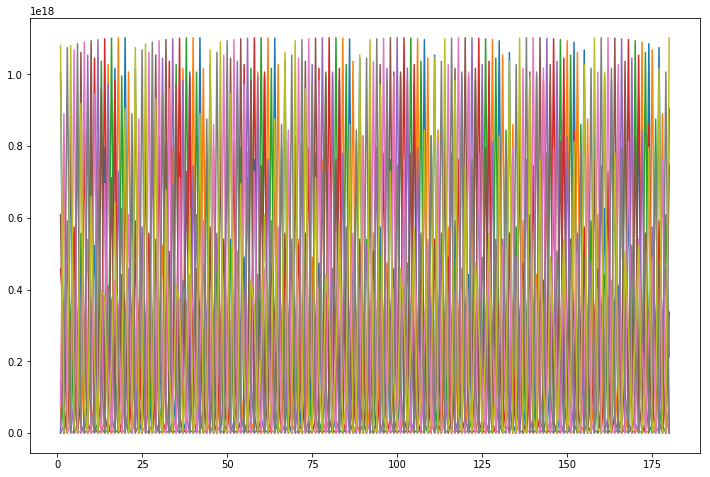

In [5]:
basis_set = make_basis_set()
xx = np.linspace(1, 180, 180)
plt.figure(figsize=(12,8))
plt.plot(xx, basis_set)
plt.show()

In [6]:
def make_stimulus_mask(trng):
    stim_mask = np.zeros((trng.shape[1], 180))
    stim_mask[np.arange(trng.shape[1]), trng] = 1
    return stim_mask

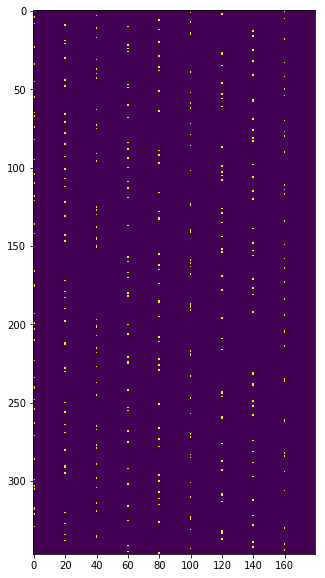

In [7]:
stim_mask = make_stimulus_mask(trng)
plt.figure(figsize=(8, 10))
plt.imshow(stim_mask)

In [8]:
trnX = stim_mask@basis_set

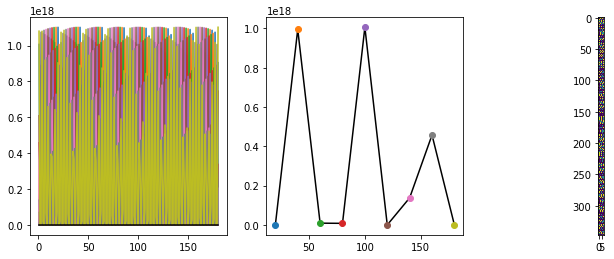

In [9]:
tr_num = 6
chan_center = np.linspace(180/n_ori_chans, 180, n_ori_chans)

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(1, 3, 1)
ax0.plot(xx, basis_set)
ax0.plot(xx, stim_mask[tr_num, :], 'k-')

ax1 = fig.add_subplot(1, 3, 2)
ax1.plot(chan_center, trnX[tr_num, :], 'k-')
for cc in range(n_ori_chans):
    ax1.plot(chan_center[cc], trnX[tr_num, cc], 'o')

ax2 = fig.add_subplot(1, 3, 3)
ax2.imshow(trnX)

plt.show()

In [10]:
trn_ou = np.unique(trng)
trn_repnum = np.zeros(trng.shape[1])
n_trials_per_orientation = np.zeros((len(trn_ou), 1))
trng_flat = trng[0, :]

for ii in range(len(trn_ou)):
    num_idx = trng_flat==trn_ou[ii]
    n_trials = trng_flat[num_idx].shape[0]
    n_trials_per_orientation[ii] = n_trials
    trn_repnum[num_idx] = np.arange(n_trials)

trn_repnum[trn_repnum > np.min(n_trials_per_orientation)] = np.nan

trng_cv = trng_flat[~np.isnan(trn_repnum)]
trn_cv = trn[~np.isnan(trn_repnum)]
trnX_cv = trnX[~np.isnan(trn_repnum)]

trn_cv_coeffs = np.zeros((trn_cv.shape[0], 2*trn_cv.shape[1], trn_cv.shape[2]))
trn_cv_coeffs[:, :trn_cv.shape[1], :] = np.real(trn_cv)
trn_cv_coeffs[:, trn_cv.shape[1]:, :] = np.imag(trn_cv)

trn_repnum = trn_repnum[~np.isnan(trn_repnum)]

chan_resp_cv_coeffs = np.zeros((trn_cv_coeffs.shape[0], chan_center.shape[0], trn_cv_coeffs.shape[2]))

In [11]:
chan_resp_cv_coeffs.shape

(323, 9, 288)

In [12]:
for i in range(int(np.max(trn_repnum))):
    trn_idx = trn_repnum != i
    tst_idx = trn_repnum == i

    cur_trn = trn_cv_coeffs[trn_idx, :, :]
    cur_tst = trn_cv_coeffs[tst_idx, :, :]

    for j in range(0, cur_trn.shape[2]):
        cur_trn_pt = cur_trn[:, :, j]
        cur_tst_pt = cur_tst[:, :, j]

        w_coeffs = np.linalg.lstsq(trnX_cv[trn_idx, :], cur_trn_pt)[0]
        
        wT_w_inv= np.linalg.inv(w_coeffs @ w_coeffs.T)
        wT_b = w_coeffs @ cur_tst_pt.T
        chan_resp_cv_coeffs[tst_idx, :, j] = wT_w_inv @ wT_b

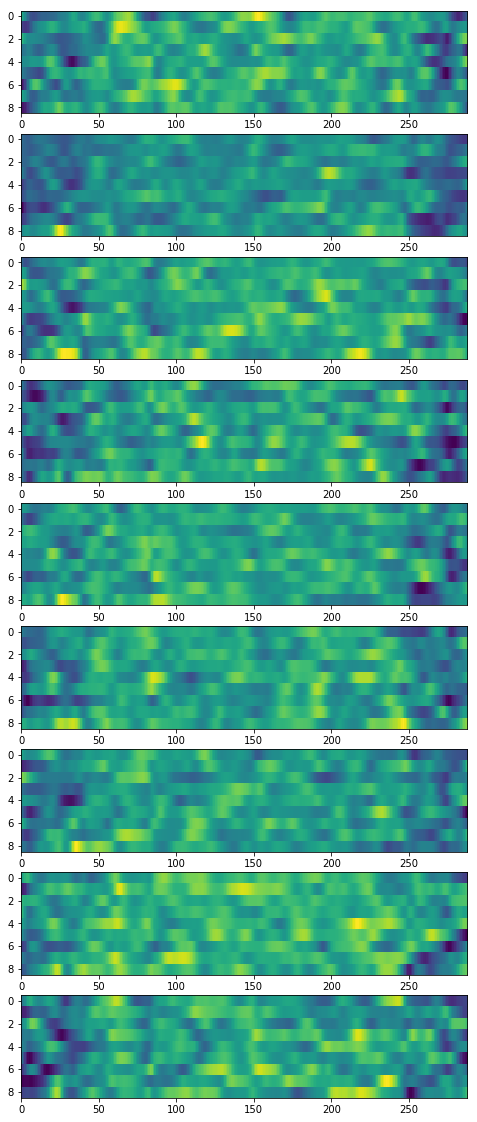

In [19]:
fig = plt.figure(figsize=(8, 20))
for i in range(n_ori_chans):
    ax = fig.add_subplot(n_ori_chans, 1, i+1)

    idx = trng_cv==trn_ou[i]
    ax.imshow(chan_resp_cv_coeffs[idx, :, :].mean(axis=0), aspect="auto")

plt.show()

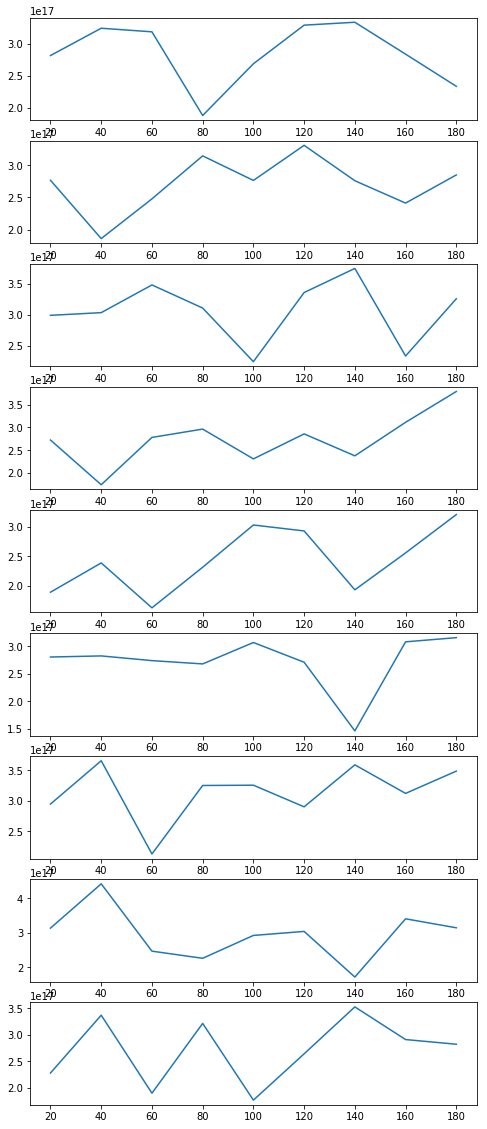

In [21]:
coeff_mean = chan_resp_cv_coeffs[:, :, 40:200].mean(axis=2)

fig = plt.figure(figsize=(8, 20))
for i in range(n_ori_chans):
    ax = fig.add_subplot(n_ori_chans, 1, i+1)
    idx = trng_cv == trn_ou[i]

    ax.plot(chan_center, coeff_mean[idx].mean(axis=0))

In [23]:
chan_resp_cv_coeffs_shift = np.zeros(chan_resp_cv_coeffs.shape)
tar_idx = int(np.round(chan_center.shape[0] / 2))
for i in range(n_ori_chans):
    idx = trng_cv == trn_ou[i]
    chan_resp_cv_coeffs_shift[idx, :, :] = np.roll(chan_resp_cv_coeffs[idx, :, :], tar_idx - i, axis=1)

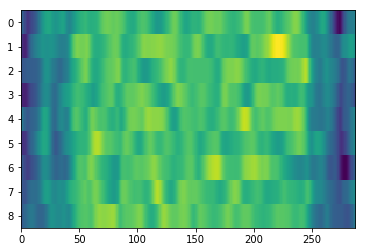

In [25]:
plt.imshow(chan_resp_cv_coeffs_shift.mean(axis=0), aspect='auto')
plt.show()

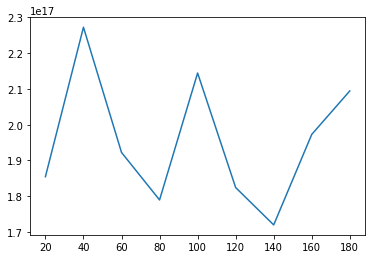

In [26]:
shift_coeffs_mean = chan_resp_cv_coeffs_shift.mean(axis=2)
plt.plot(chan_center, shift_coeffs_mean.mean(axis=0))